In [16]:
from election import *
from voters import *
from parties import *
from sampling import *
import matplotlib.pyplot as plt
from plotting import *

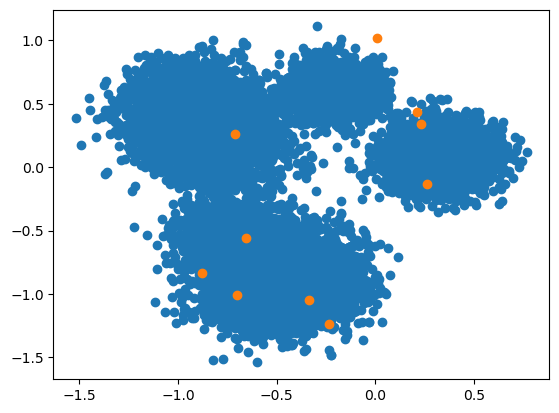

In [17]:
np.random.seed(43)
DEMOGRAPHIC = {Saint:[[] for i in range(10000)], 
               Spineless:[[]for i in range(1)],
               Follower:[[2] for i in range(1000)], Follower:[[3] for i in range(1000)], Follower:[[4] for i in range(1000)],
               Opportunist:[[2] for i in range(1000)], Opportunist:[[3] for i in range(1000)], Opportunist:[[4] for i in range(1000)],
               Strategist:[[3,2] for i in range(1000)]
               }

NUM_PARTIES = 10
NUM_CLUSTERS = 7
DIM = 2
RANGE_MEANS = [-1, 1]
RANGE_V_STD = [0.1, 0.2]
RANGE_P_STD = [0.1, 0.3]

means = list(np.random.uniform(RANGE_MEANS[0], RANGE_MEANS[1], (NUM_CLUSTERS, DIM)))
pstds = np.random.uniform(RANGE_P_STD[0], RANGE_P_STD[1], NUM_CLUSTERS)
vstds = np.random.uniform(RANGE_V_STD[0], RANGE_V_STD[1], NUM_CLUSTERS)
weights = np.random.rand(NUM_CLUSTERS)
weights /= sum(weights)

party_modes = {'modes':[{'mean': means[i], 'std':pstds[i], 'weight':weights[i]} for i in range(NUM_CLUSTERS)]}
voter_modes = {'modes':[{'mean': means[i], 'std':vstds[i], 'weight':weights[i]} for i in range(NUM_CLUSTERS)]}


parties = sample_parties(NUM_PARTIES, distribution='multimodal', dim=2, params=party_modes)
voters = sample_voters(DEMOGRAPHIC, parties, distribution='multimodal', dim=2, params=voter_modes)

plt.scatter([voter.position[0] for voter in voters], [voter.position[1] for voter in voters])
plt.scatter([party.position[0] for party in parties], [party.position[1] for party in parties])

In [18]:
myelection = DHondt(voters, parties, num_seats=150, num_polls=5)
[party.compute_poldeg(myelection.voters) for party in myelection.parties]
results = myelection.run()
results[0], results[-1]

(Counter({Party(b, 0.0): 42,
          Party(d, 0.0): 21,
          Party(e, 0.0): 19,
          Party(j, 0.0): 15,
          Party(c, 0.06): 13,
          Party(h, 0.0): 13,
          Party(g, 0.17): 12,
          Party(i, 0.0): 10,
          Party(a, 0.05): 4,
          Party(f, 0.02): 1}),
 Counter({Party(b, 0.0): 47,
          Party(d, 0.0): 23,
          Party(e, 0.0): 19,
          Party(j, 0.0): 16,
          Party(c, 0.06): 11,
          Party(h, 0.0): 11,
          Party(g, 0.17): 10,
          Party(i, 0.0): 9,
          Party(a, 0.05): 3,
          Party(f, 0.02): 1}))

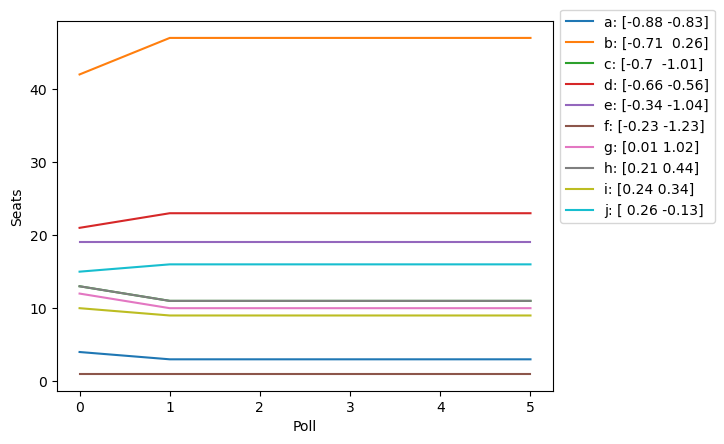

In [19]:
plot_seats_over_time(results)